In [4]:
import os
from database.milvus_cloud_db.zilliz_retriever import semantic_search, initialize_retriever, semantic_search_clean
from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages
from langgraph.graph import StateGraph 
from IPython.display import Image, display
from langgraph.prebuilt import ToolNode, tools_condition
from langchain.agents import Tool
from langchain.tools import StructuredTool
from typing import Annotated, Dict, Any, List
from llm_model.llm import llm_model
from pydantic import BaseModel
import random
import json

### Define tools

In [28]:

# Initialize retriever
init_result = initialize_retriever(
    zilliz_uri= "https://in03-d9c913fef2464e7.serverless.aws-eu-central-1.cloud.zilliz.com",
    zilliz_token= "db_d9c913fef2464e7:Sh9&pO+<)v{>{0]1",
    collection_name= "mental_health_emori",
    embedding_model= "all-MiniLM-L6-v2",
    use_cuda= False
)
print(init_result)


Retriever initialized successfully


In [37]:
semantic_search_clean("mental healh awareness", top_k=5, threshold=0.5)

['mental illness promote early detection of mental illness, improve mental health outcomes, and improve mental health services 25,31. A recent study investigated the relationship between college students’ familiarity with active minds, mental health education, and awareness 32. In this study, students familiar with active-mind learning were associated with increased knowledge and decreased mental health stigma over time. Dealing with public stigma may reduce the likelihood of personal stigma for service users and make it easier to seek help and engage in mental health care 2. Snyder14 demonstrated that a mental health awareness campaign and communication could address the lack of awareness',
 'illness promote early detection of mental illness, improve mental health outcomes, and improve mental health services 25,31. A recent study investigated the relationship between college students’ familiarity with active minds, mental health education, and awareness 32. In this study, students fam

In [38]:
# Simple state structure for stateless RAG
def create_initial_state(query: str) -> Dict[str, Any]:
    return {
        "user_query": query,
        "retrieved_docs": [],
        "final_response": "",
        "context": ""
    }
    


In [66]:
# Cell 2: Retrieval Function
def retrieve_documents(state: Dict[str, Any]) -> Dict[str, Any]:
    query = state["user_query"]
    
    # Use your semantic search function
    results = semantic_search_clean(query, top_k=10 )
    
    # Extract document content
    retrieved_docs = []
    for result in results:
        retrieved_docs.append(result)
    
    # Update state
    state["retrieved_docs"] = retrieved_docs
    
    print(f"Retrieved {len(retrieved_docs)} documents for query: {query}")
    
    return state

In [67]:
# Cell 3: Context Preparation Function
def prepare_context(state: Dict[str, Any]) -> Dict[str, Any]:
    retrieved_docs = state["retrieved_docs"]
    
    # Combine retrieved documents into context
    context_parts = []
    for i, doc in enumerate(retrieved_docs):
        context_parts.append(f"Document {i+1}: {doc}")
    
    context = "\n\n".join(context_parts)
    state["context"] = context
    
    print(f"Prepared context from {len(retrieved_docs)} documents")
    
    return state

In [76]:
# Cell 4: LLM Generation Function
def generate_response(state: Dict[str, Any]) -> Dict[str, Any]:
    user_query = state["user_query"]
    context = state["context"]
    
    # Create prompt for LLM
    prompt = f"""
    you are a helpful AI assistant,
    Use only the provided context below to answer the question given by the user. Dont use any additional information.
    start your response with answer to the question directly without mentioning retrieved documents.
    Context:{context}
    Question: {user_query} 
    Answer:
    
    Important:
    - if you dont have answer for that question, just say "I don't have information about that"
"""
    
    # Replace with your LLM call
    # response = your_llm_client.generate(prompt)
    response = llm_model.invoke(prompt)
    
    state["final_response"] = response
    
    print(f"Generated response for query: {user_query}")
    
    return state

In [77]:
# Cell 5: LangGraph Setup
def create_rag_graph():
    # Create the graph
    workflow = StateGraph(dict)
    
    # Add nodes
    workflow.add_node("retrieve", retrieve_documents)
    workflow.add_node("prepare_context", prepare_context)
    workflow.add_node("generate", generate_response)
    
    # Add edges
    workflow.set_entry_point("retrieve")
    workflow.add_edge("retrieve", "prepare_context")
    workflow.add_edge("prepare_context", "generate")
    workflow.add_edge("generate", END)
    
    # Compile the graph
    app = workflow.compile()
    
    return app

# Create the RAG application
rag_app = create_rag_graph()


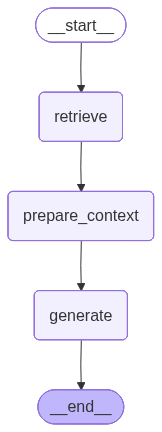

In [78]:
display(Image(rag_app.get_graph().draw_mermaid_png()))

In [79]:
# Cell 6: RAG Execution Function
def run_rag(query: str) -> str:
    # Create initial state
    initial_state = create_initial_state(query)
    
    # Run the RAG pipeline
    result = rag_app.invoke(initial_state)
    
    # Return final response
    return result["final_response"]

In [80]:
# Test function
def test_rag(query: str):
    print(f"Query: {query}")
    response = run_rag(query)
    print(f"Response: {response}")
    return response

In [82]:
query = "how to porvide awareness about mental health to the youth"
result = run_rag(query)
print(result)

Retrieved 10 documents for query: how to porvide awareness about mental health to the youth
Prepared context from 10 documents
Generated response for query: how to porvide awareness about mental health to the youth
content='To provide awareness about mental health to the youth, implement school-based mental health literacy programs that aim to improve knowledge, attitudes, and help-seeking behaviors among young people. Educate young people about mental health and mental illness through targeted programs and evaluate their effectiveness to ensure the messages are impactful.' additional_kwargs={'refusal': None} response_metadata={'token_usage': {'completion_tokens': 58, 'prompt_tokens': 2052, 'total_tokens': 2110, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4.1-nano-2025-04-14', 'system_fingerprint': 'fp_7c233

In [64]:
result

AIMessage(content='Mental health awareness among students is increasingly emphasized by researchers because many college students suffer from mental health issues, which can affect their lives and educational experiences. Providing mental health education and training helps students learn and understand issues related to mental illness, demonstrating a positive impact on their attitudes toward mental health.', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 57, 'prompt_tokens': 679, 'total_tokens': 736, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4.1-nano-2025-04-14', 'system_fingerprint': 'fp_04d3664870', 'id': 'chatcmpl-CGrt64VaOQOjoCvLf1F92gEUVT3ya', 'service_tier': 'default', 'finish_reason': 'stop', 'logprobs': None}, id='run--6e261f6b-2ef6-48f1-8864-edc619a7

In [16]:
def print_full_result(query: str):
    initial_state = create_initial_state(query)
    final_state = rag_app.invoke(initial_state)
    
    # print("Query:", final_state["user_query"])
    # print("Retrieved docs:", len(final_state["retrieved_docs"]))
    print("Response:", final_state["final_response"])

# Usage
print_full_result("I feel tired")

Retrieved 5 documents for query: I feel tired
Prepared context from 5 documents
Generated response for query: I feel tired
Response: content='The provided documents do not contain information related to feeling tired.' additional_kwargs={'refusal': None} response_metadata={'token_usage': {'completion_tokens': 12, 'prompt_tokens': 1208, 'total_tokens': 1220, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 1024}}, 'model_name': 'gpt-4.1-nano-2025-04-14', 'system_fingerprint': 'fp_04d3664870', 'id': 'chatcmpl-CGrgFBEbJDDk1xLTmmJ3P11OdJEtO', 'service_tier': 'default', 'finish_reason': 'stop', 'logprobs': None} id='run--8e01a302-641b-40b3-b096-0f1c2a0a0694-0' usage_metadata={'input_tokens': 1208, 'output_tokens': 12, 'total_tokens': 1220, 'input_token_details': {'audio': 0, 'cache_read': 1024}, 'output_token_details': {'audio': 0, 'reasonin